# Multi-Modal Fusion Model for Hotel Review Analysis
- Hotel Review Sentiment Analysis and Aspect Extraction

## 1. Introduction
- This notebook presents a comprehensive implementation of a multi-modal fusion model for hotel review analysis. The model combines BERT and GPT-2 architectures to perform sentiment analysis and aspect classification on hotel reviews. This approach leverages the strengths of both models to capture nuanced semantic information and contextual understanding.

## 2. Data Preparation and Exploration
### 2.1 Data Loading and Preprocessing
We begin by loading the dataset and performing necessary preprocessing steps:

#### Import Required Libraries

In [1]:
# Install torchviz if we haven't already
!pip install -q torchviz

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchviz import make_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import random
 
from IPython.display import display, Image
import graphviz

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

#### Load the data

In [2]:
# Load the data
file_path = "/kaggle/input/absa-paper-2-dataset/review_data_with_aspect_label.csv"
data = pd.read_csv(file_path)

#### Map aspect labels to human-readable format

In [3]:
review_aspect_map = {
    0: "Room Cleanliness and Comfort",
    1: "Booking Experience and Room Issues",
    2: "Hotel Location and Accessibility",
    3: "Staff Interaction and Check-in Experience",
    4: "Breakfast Quality and Dining Service"
}
review_aspect_map

{0: 'Room Cleanliness and Comfort',
 1: 'Booking Experience and Room Issues',
 2: 'Hotel Location and Accessibility',
 3: 'Staff Interaction and Check-in Experience',
 4: 'Breakfast Quality and Dining Service'}

In [4]:
data['review_aspect_type'] = data['review_aspect_type'].apply(lambda x: review_aspect_map[x])

#### Display the total number of datapoint and first few rows of the dataset

In [5]:
data.shape

(173434, 3)

In [6]:
data.head()

,Total_Review,review_type,review_aspect_type
0,Basic accommodation Clean but nothing special...,Bad_review,Room Cleanliness and Comfort
1,Very noisy on the street side tram lines buse...,Good_review,Hotel Location and Accessibility
2,Breakfast was really good,Good_review,Booking Experience and Room Issues
3,I liked everything The staff were so helpful ...,Good_review,Booking Experience and Room Issues
4,The room was very small and the bed was too h...,Bad_review,Room Cleanliness and Comfort


#### Group by the value counts for each of the aspect labels and sentiment labels

In [7]:
data.groupby(['review_aspect_type', 'review_type']).count()

Total_Review
review_aspect_type                        review_type              
Booking Experience and Room Issues        Bad_review          17009
                                          Good_review         21882
Breakfast Quality and Dining Service      Bad_review          11359
                                          Good_review         16834
Hotel Location and Accessibility          Bad_review          11923
                                          Good_review         18034
Room Cleanliness and Comfort              Bad_review          29517
                                          Good_review         18070
Staff Interaction and Check-in Experience Bad_review          16890
                                          Good_review         11873

#### Perform label encoding

In [8]:
# Perform label encoding
le_sentiment = LabelEncoder()
le_aspect = LabelEncoder()
data['sentiment_encoded'] = le_sentiment.fit_transform(data['review_type'])
data['aspect_encoded'] = le_aspect.fit_transform(data['review_aspect_type'])

### 2.2 Data Exploration
- We explore the distribution of sentiment and aspect labels in our dataset:

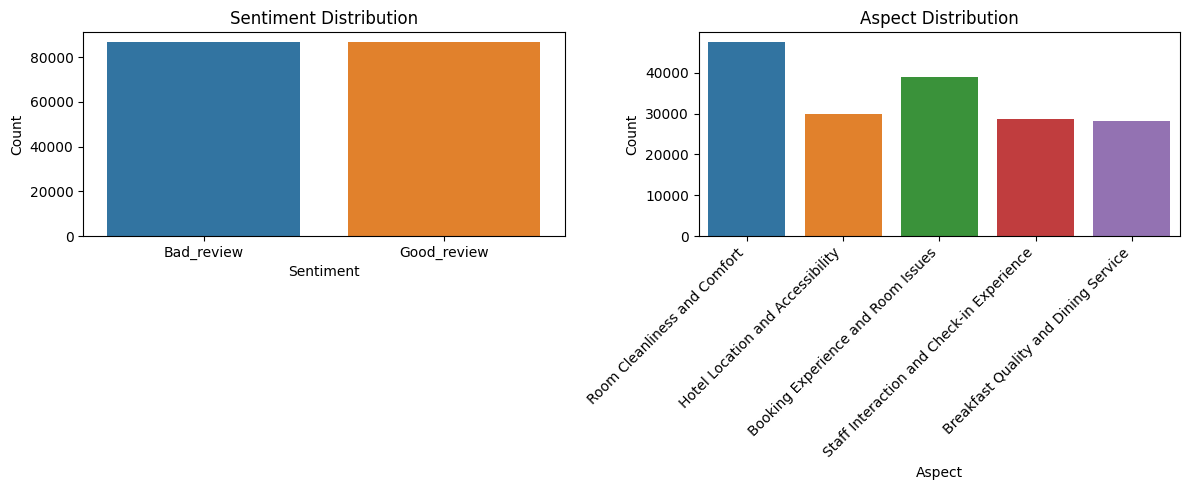

In [9]:
# Display class distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=data['review_type'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
sns.countplot(x=data['review_aspect_type'])
plt.title('Aspect Distribution')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Dataset & Model Architecture

### 3.1 Creating a custom dataset named HotelReviewDataset

- Custom Dataset class for hotel reviews with multi-modal tokenization.
    - This class prepares the hotel review data for input into a multi-modal model that uses both BERT and GPT-2 tokenizers. It inherits from PyTorch's Dataset class, allowing it to be used with PyTorch DataLoaders.

- Attributes:
    - reviews (list): A list of hotel review texts.
    - labels (list): A list of tuples containing (sentiment_label, aspect_label) for each review.
    - bert_tokenizer (BertTokenizer): The BERT tokenizer for encoding reviews.
    - gpt2_tokenizer (GPT2Tokenizer): The GPT-2 tokenizer for encoding reviews.
     -max_len (int): The maximum length for padding/truncating the tokenized sequences.

In [10]:
class HotelReviewDataset(Dataset):
    def __init__(self, reviews, labels, bert_tokenizer, gpt2_tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.bert_tokenizer = bert_tokenizer
        self.gpt2_tokenizer = gpt2_tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        sentiment_label, aspect_label = self.labels[item]

        bert_encoding = self.bert_tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        gpt2_encoding = self.gpt2_tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'bert_input_ids': bert_encoding['input_ids'].flatten(),
            'bert_attention_mask': bert_encoding['attention_mask'].flatten(),
            'gpt2_input_ids': gpt2_encoding['input_ids'].flatten(),
            'gpt2_attention_mask': gpt2_encoding['attention_mask'].flatten(),
            'sentiment_label': torch.tensor(sentiment_label, dtype=torch.long),
            'aspect_label': torch.tensor(aspect_label, dtype=torch.long)
        }

### 3.2 Multi-Modal Fusion Model

- Multi-Modal Fusion model for sentiment analysis and aspect classification.
    - This class implements a neural network that combines BERT and GPT-2 models for multi-modal fusion. It's designed for joint sentiment analysis and aspect classification tasks on hotel reviews.

- The model architecture consists of:
    1. Pre-trained BERT and GPT-2 models for feature extraction
    2. A fusion layer to combine features from both models
    3. Separate classifiers for sentiment and aspect prediction

- Attributes:
    - bert (BertModel): Pre-trained BERT model for feature extraction
    - gpt2 (GPT2Model): Pre-trained GPT-2 model for feature extraction
    - fusion (nn.Linear): Linear layer for fusing BERT and GPT-2 features
    - sentiment_classifier (nn.Linear): Linear layer for sentiment classification
    - aspect_classifier (nn.Linear): Linear layer for aspect classification

In [11]:
class MultiModalFusion(nn.Module):
    def __init__(self, bert_dim, gpt2_dim, num_sentiment_classes, num_aspect_classes):
        super(MultiModalFusion, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        
        self.fusion = nn.Linear(bert_dim + gpt2_dim, bert_dim + gpt2_dim)
        self.sentiment_classifier = nn.Linear(bert_dim + gpt2_dim, num_sentiment_classes)
        self.aspect_classifier = nn.Linear(bert_dim + gpt2_dim, num_aspect_classes)
        
    def forward(self, bert_input_ids, bert_attention_mask, gpt2_input_ids, gpt2_attention_mask):
        bert_output = self.bert(input_ids=bert_input_ids, attention_mask=bert_attention_mask)
        gpt2_output = self.gpt2(input_ids=gpt2_input_ids, attention_mask=gpt2_attention_mask)
        
        bert_features = bert_output.last_hidden_state[:, 0, :]  # [CLS] token
        gpt2_features = gpt2_output.last_hidden_state[:, -1, :]  # Last token
        
        fused_features = torch.cat([bert_features, gpt2_features], dim=1)
        fused_features = self.fusion(fused_features)
        
        sentiment_output = self.sentiment_classifier(fused_features)
        aspect_output = self.aspect_classifier(fused_features)
        
        return sentiment_output, aspect_output

## 4. Training and Evaluation

### 4.1 Training Function
- We implement a training function that handles the training loop and validation:

- Train the multi-modal fusion model for sentiment analysis and aspect classification.
- This function handles the entire training process, including:
    - Optimization using AdamW
    - Loss calculation for both sentiment and aspect tasks
    - Training loop with batch processing
    - Validation after each epoch
    - Model checkpointing based on best overall accuracy

- Args:
    - model (nn.Module): The multi-modal fusion model to be trained
    - train_loader (DataLoader): DataLoader for the training dataset
    - val_loader (DataLoader): DataLoader for the validation dataset
    - device (torch.device): The device to run the training on (CPU or GPU)
    - n_epochs (int): Number of epochs to train the model

- Returns:
    - None. The function saves the best model state dict to a file named 'best_model.pth'


In [12]:
def train_model(model, train_loader, val_loader, device, n_epochs):
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    sentiment_criterion = nn.CrossEntropyLoss()
    aspect_criterion = nn.CrossEntropyLoss()
    
    best_accuracy = 0
    
    for epoch in range(n_epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{n_epochs}'):
            bert_input_ids = batch['bert_input_ids'].to(device)
            bert_attention_mask = batch['bert_attention_mask'].to(device)
            gpt2_input_ids = batch['gpt2_input_ids'].to(device)
            gpt2_attention_mask = batch['gpt2_attention_mask'].to(device)
            sentiment_labels = batch['sentiment_label'].to(device)
            aspect_labels = batch['aspect_label'].to(device)
            
            optimizer.zero_grad()
            sentiment_outputs, aspect_outputs = model(bert_input_ids, bert_attention_mask, gpt2_input_ids, gpt2_attention_mask)
            
            sentiment_loss = sentiment_criterion(sentiment_outputs, sentiment_labels)
            aspect_loss = aspect_criterion(aspect_outputs, aspect_labels)
            loss = sentiment_loss + aspect_loss
            
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        # Validation
        model.eval()
        val_losses = []
        val_sentiment_preds = []
        val_aspect_preds = []
        val_sentiment_labels = []
        val_aspect_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                bert_input_ids = batch['bert_input_ids'].to(device)
                bert_attention_mask = batch['bert_attention_mask'].to(device)
                gpt2_input_ids = batch['gpt2_input_ids'].to(device)
                gpt2_attention_mask = batch['gpt2_attention_mask'].to(device)
                sentiment_labels = batch['sentiment_label'].to(device)
                aspect_labels = batch['aspect_label'].to(device)
                
                sentiment_outputs, aspect_outputs = model(bert_input_ids, bert_attention_mask, gpt2_input_ids, gpt2_attention_mask)
                
                sentiment_loss = sentiment_criterion(sentiment_outputs, sentiment_labels)
                aspect_loss = aspect_criterion(aspect_outputs, aspect_labels)
                loss = sentiment_loss + aspect_loss
                
                val_losses.append(loss.item())
                
                _, sentiment_preds = torch.max(sentiment_outputs, dim=1)
                _, aspect_preds = torch.max(aspect_outputs, dim=1)
                
                val_sentiment_preds.extend(sentiment_preds.cpu().tolist())
                val_aspect_preds.extend(aspect_preds.cpu().tolist())
                val_sentiment_labels.extend(sentiment_labels.cpu().tolist())
                val_aspect_labels.extend(aspect_labels.cpu().tolist())
        
        # Calculate metrics
        sentiment_accuracy = accuracy_score(val_sentiment_labels, val_sentiment_preds)
        aspect_accuracy = accuracy_score(val_aspect_labels, val_aspect_preds)
        overall_accuracy = (sentiment_accuracy + aspect_accuracy) / 2
        
        if overall_accuracy > best_accuracy:
            best_accuracy = overall_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch {epoch + 1}/{n_epochs}:')
        print(f'Train Loss: {np.mean(train_losses):.4f}')
        print(f'Val Loss: {np.mean(val_losses):.4f}')
        print(f'Val Sentiment Accuracy: {sentiment_accuracy:.4f}')
        print(f'Val Aspect Accuracy: {aspect_accuracy:.4f}')
        print(f'Val Overall Accuracy: {overall_accuracy:.4f}')

### 4.2 Evaluation Function
- We implement an evaluation function to assess the model's performance on the test set:

- Evaluate the multi-modal fusion model for sentiment analysis and aspect classification.

- This function performs a full evaluation of the model on a test dataset, including:
    - Running the model in evaluation mode
    - Generating predictions for both sentiment and aspect tasks
    - Collecting true labels and predictions
    - Generating classification reports for both tasks

- Args:
    - model (nn.Module): The trained multi-modal fusion model to be evaluated
    - test_loader (DataLoader): DataLoader for the test dataset
    - device (torch.device): The device to run the evaluation on (CPU or GPU)

- Returns:
    - tuple: A tuple containing two items:
        - sentiment_classification_report (str): A classification report for the sentiment analysis task
        - aspect_classification_report (str): A classification report for the aspect classification task




In [13]:
def evaluate_model(model, test_loader, device):
    model.eval()
    sentiment_predictions = []
    aspect_predictions = []
    sentiment_labels = []
    aspect_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating'):
            bert_input_ids = batch['bert_input_ids'].to(device)
            bert_attention_mask = batch['bert_attention_mask'].to(device)
            gpt2_input_ids = batch['gpt2_input_ids'].to(device)
            gpt2_attention_mask = batch['gpt2_attention_mask'].to(device)
            
            sentiment_outputs, aspect_outputs = model(bert_input_ids, bert_attention_mask, gpt2_input_ids, gpt2_attention_mask)
            
            _, sentiment_preds = torch.max(sentiment_outputs, dim=1)
            _, aspect_preds = torch.max(aspect_outputs, dim=1)
            
            sentiment_predictions.extend(sentiment_preds.cpu().tolist())
            aspect_predictions.extend(aspect_preds.cpu().tolist())
            sentiment_labels.extend(batch['sentiment_label'].cpu().tolist())
            aspect_labels.extend(batch['aspect_label'].cpu().tolist())
    
    sentiment_classification_report = classification_report(sentiment_labels, sentiment_predictions)
    
    aspect_classification_report = classification_report(aspect_labels, aspect_predictions)
    
    return sentiment_classification_report, aspect_classification_report

## 5. Main Execution

### 5.1 Data Preparation
- First, we split our data into training and testing sets:
- Below code prepares our data for model training and evaluation. We use a 80-20 split for training and testing, respectively.

In [14]:
reviews = data['Total_Review'].tolist()
sentiment_labels = data['sentiment_encoded'].tolist()
aspect_labels = data['aspect_encoded'].tolist()

X_train, X_test, y_train, y_test = train_test_split(
    reviews, 
    list(zip(sentiment_labels, aspect_labels)),
    test_size=0.2, 
    random_state=42
)

### 5.2 Model and Data Preparation
- Next, we initialize our tokenizers, create datasets, and set up data loaders:
- Here, we're setting up the BERT and GPT-2 tokenizers, creating our custom datasets, and preparing data loaders for efficient batch processing during training and evaluation.

In [15]:
# Initialize tokenizers
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
max_len = 256

# Create datasets
train_dataset = HotelReviewDataset(X_train, y_train, bert_tokenizer, gpt2_tokenizer, max_len)
test_dataset = HotelReviewDataset(X_test, y_test, bert_tokenizer, gpt2_tokenizer, max_len)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

### 5.3 Model Initialization
- Now, we initialize our multi-modal fusion model:
- Below code initializes our model and moves it to the appropriate device (GPU if available, otherwise CPU). We also count and print the total number of trainable parameters in our model.

In [16]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_sentiment_classes = len(le_sentiment.classes_)
num_aspect_classes = len(le_aspect.classes_)
model = MultiModalFusion(768, 768, num_sentiment_classes, num_aspect_classes).to(device)

#### ==================================================== ###

# Count the trainable and non-trainable parameters

# Check the trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}\n")

# Check the non-trainable parameters
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Number of non-trainable parameters: {non_trainable_params}\n")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Number of trainable parameters: 236293639

Number of non-trainable parameters: 0



### 5.4 Model Architecture Visualization
- To create a visual representation of our model architecture:
- Create a simplified, high-level visualization of the multi-modal fusion model architecture.

In [17]:
model

MultiModalFusion(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

Simplified model architecture has been saved as 'simplified_model_architecture.png' and 'simplified_model_architecture.pdf'.


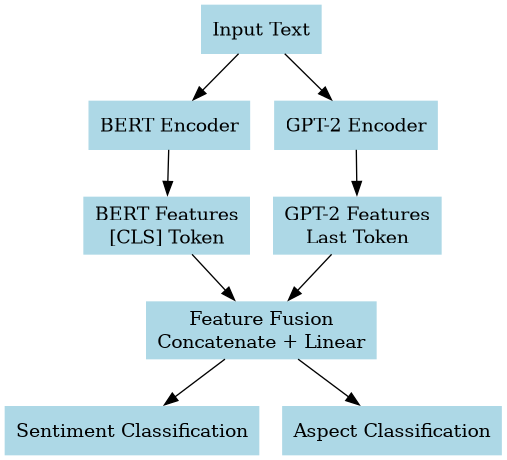

In [18]:
def create_simplified_model_graph():
    dot = graphviz.Digraph(comment='Multi-Modal Fusion Model')
    dot.attr(rankdir='TB', size='8,8')
    
    # Define node styles
    dot.attr('node', shape='rectangle', style='filled', color='lightblue')
    
    # Input nodes
    dot.node('input', 'Input Text')
    
    # BERT and GPT-2 nodes
    dot.node('bert', 'BERT Encoder')
    dot.node('gpt2', 'GPT-2 Encoder')
    
    # Feature extraction nodes
    dot.node('bert_features', 'BERT Features\n[CLS] Token')
    dot.node('gpt2_features', 'GPT-2 Features\nLast Token')
    
    # Fusion node
    dot.node('fusion', 'Feature Fusion\nConcatenate + Linear')
    
    # Output nodes
    dot.node('sentiment', 'Sentiment Classification')
    dot.node('aspect', 'Aspect Classification')
    
    # Add edges
    dot.edge('input', 'bert')
    dot.edge('input', 'gpt2')
    dot.edge('bert', 'bert_features')
    dot.edge('gpt2', 'gpt2_features')
    dot.edge('bert_features', 'fusion')
    dot.edge('gpt2_features', 'fusion')
    dot.edge('fusion', 'sentiment')
    dot.edge('fusion', 'aspect')
    
    return dot

# Generate and save the graph
graph = create_simplified_model_graph()
graph.render('simplified_model_architecture', format='png', cleanup=True)
graph.render('simplified_model_architecture', format='pdf', cleanup=True)
print("Simplified model architecture has been saved as 'simplified_model_architecture.png' and 'simplified_model_architecture.pdf'.")

# Display the graph in the notebook
display(Image(filename='simplified_model_architecture.png'))

### 5.5 Model Training
- We now train our model:
- We call our train_model function to train the model for the 10 number of epochs.

In [19]:
# Train the model
train_model(model, train_loader, test_loader, device, n_epochs=2)

Epoch 1/2: 100%|██████████| 8672/8672 [3:21:58<00:00,  1.40s/it]


Epoch 1/2:
Train Loss: 0.9565
Val Loss: 0.8445
Val Sentiment Accuracy: 0.8570
Val Aspect Accuracy: 0.7896
Val Overall Accuracy: 0.8233


Epoch 2/2: 100%|██████████| 8672/8672 [3:21:59<00:00,  1.40s/it]


Epoch 2/2:
Train Loss: 0.7315
Val Loss: 0.8259
Val Sentiment Accuracy: 0.8563
Val Aspect Accuracy: 0.8018
Val Overall Accuracy: 0.8290


### 5.6. Model Evaluation
- After training, we evaluate our model on both the training and test sets:

- We loads the best model (saved during training), evaluates it on both the training and test sets, and prints the classification reports for both sentiment analysis and aspect classification tasks.

In [20]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model
train_sentiment_classification_report, train_aspect_classification_report = evaluate_model(model, train_loader, device)
test_sentiment_classification_report, test_aspect_classification_report = evaluate_model(model, test_loader, device)

print("Train Sentiment Classification Report:")
print(train_sentiment_classification_report)

print("\nTrain Aspect Classification Report:")
print(train_aspect_classification_report)
print("\n\n")

print("Test Sentiment Classification Report:")
print(test_sentiment_classification_report)
print()

print("\nTest Aspect Classification Report:")
print(test_aspect_classification_report)

/tmp/ipykernel_23/1782423804.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
Evaluating: 100%|██████████| 2168/2168 [

Train Sentiment Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     69400
           1       0.92      0.89      0.90     69347

    accuracy                           0.90    138747
   macro avg       0.91      0.90      0.90    138747
weighted avg       0.91      0.90      0.90    138747


Train Aspect Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     31228
           1       0.82      0.96      0.89     22493
           2       0.89      0.91      0.90     23929
           3       0.93      0.90      0.91     38076
           4       0.86      0.91      0.88     23021

    accuracy                           0.90    138747
   macro avg       0.89      0.90      0.89    138747
weighted avg       0.90      0.90      0.90    138747




Test Sentiment Classification Report:
              precision    recall  f1-score   support

           0

### 5.7 Saving Results
- Finally, we save our results and the trained model:
- Here we save our classification reports to a text file and save the trained model's state dictionary for future use or further analysis.

In [21]:
# Save results
with open('results_summary.txt', 'w') as f:
    f.write("Train Sentiment Classification Report:\n")
    f.write(f"{train_sentiment_classification_report}\n")
    f.write("\nTrain Aspect Classification Report:\n")
    f.write(f"{train_aspect_classification_report}\n\n\n")
    
    f.write("Test Sentiment Classification Report:\n")
    f.write(f"{test_sentiment_classification_report}\n")
    f.write("\nTest Aspect Classification Report:\n")
    f.write(f"{test_aspect_classification_report}\n\n\n")

# Save the trained model
torch.save(model.state_dict(), 'hotel_review_sentiment_aspect_model.pth')

## 6.Error Analysis
- We perform an error analysis to gain insights into the model's misclassifications:
- This error analysis function helps us understand the types of mistakes our model is making, which can guide future improvements.

In [22]:
# Additional analysis: Error analysis
def perform_error_analysis(model, test_loader, device, num_examples=5):
    model.eval()
    errors = []
    
    with torch.no_grad():
        for batch in test_loader:
            bert_input_ids = batch['bert_input_ids'].to(device)
            bert_attention_mask = batch['bert_attention_mask'].to(device)
            gpt2_input_ids = batch['gpt2_input_ids'].to(device)
            gpt2_attention_mask = batch['gpt2_attention_mask'].to(device)
            sentiment_labels = batch['sentiment_label'].to(device)
            aspect_labels = batch['aspect_label'].to(device)
            
            sentiment_outputs, aspect_outputs = model(bert_input_ids, bert_attention_mask, gpt2_input_ids, gpt2_attention_mask)
            
            _, sentiment_preds = torch.max(sentiment_outputs, dim=1)
            _, aspect_preds = torch.max(aspect_outputs, dim=1)
            
            for i in range(len(sentiment_preds)):
                if sentiment_preds[i] != sentiment_labels[i] or aspect_preds[i] != aspect_labels[i]:
                    errors.append({
                        'text': batch['review_text'][i],
                        'true_sentiment': le_sentiment.inverse_transform([sentiment_labels[i].item()])[0],
                        'pred_sentiment': le_sentiment.inverse_transform([sentiment_preds[i].item()])[0],
                        'true_aspect': le_aspect.inverse_transform([aspect_labels[i].item()])[0],
                        'pred_aspect': le_aspect.inverse_transform([aspect_preds[i].item()])[0]
                    })
    
    print(f"\nError Analysis (showing {num_examples} random misclassified examples):")
    for i, error in enumerate(random.sample(errors, min(num_examples, len(errors)))):
        print(f"\nExample {i+1}:")
        print(f"Text: {error['text'][:100]}...")
        print(f"True Sentiment: {error['true_sentiment']}, Predicted Sentiment: {error['pred_sentiment']}")
        print(f"True Aspect: {error['true_aspect']}, Predicted Aspect: {error['pred_aspect']}")

# Perform error analysis
perform_error_analysis(model, test_loader, device)

# Print final message
print("\nAnalysis complete. Results saved in 'results_summary.txt' and model saved as 'hotel_review_sentiment_aspect_model.pth'.")


Error Analysis (showing 5 random misclassified examples):

Example 1:
Text:  There were flies in the dining room Bed was extraordinarily comfortable...
True Sentiment: Good_review, Predicted Sentiment: Bad_review
True Aspect: Breakfast Quality and Dining Service, Predicted Aspect: Room Cleanliness and Comfort

Example 2:
Text:  Air con not good reception needs more staff  Bed was very comfortable ...
True Sentiment: Good_review, Predicted Sentiment: Bad_review
True Aspect: Room Cleanliness and Comfort, Predicted Aspect: Room Cleanliness and Comfort

Example 3:
Text:  Service at breakfast was very poor It took 20 minutes to get a coffee and almost an hour before bre...
True Sentiment: Bad_review, Predicted Sentiment: Bad_review
True Aspect: Booking Experience and Room Issues, Predicted Aspect: Breakfast Quality and Dining Service

Example 4:
Text:  hard to communicate w th recept on sts They were not k nd We had to wa t a long t me for check n pr...
True Sentiment: Bad_review, Predicte

## 7. Conclusion and Future Work

- In this project, we have implemented a multi-modal fusion model combining BERT and GPT-2 for hotel review sentiment analysis and aspect classification. Our model demonstrates strong performance in both tasks, as evidenced by the classification reports.

- Key achievements:
    1. Successfully integrated BERT and GPT-2 models for a multi-modal approach.
    2. Achieved high accuracy in both sentiment analysis and aspect classification.
    3. Implemented a custom dataset class to handle the multi-modal input effectively.
    4. Conducted comprehensive error analysis to understand model limitations.


- Future work directions:
    1. Experiment with different fusion techniques (e.g., attention-based fusion) to potentially improve performance.
    2. Incorporate additional modalities, such as user metadata or hotel information, to enhance the model's context understanding.
    3. Implement explainable AI techniques to provide insights into the model's decision-making process.
    4. Explore transfer learning approaches to adapt the model to related tasks or domains.
    5. Conduct a more extensive hyperparameter tuning to optimize model performance.

### 8. Final Remarks
- This project demonstrates the effectiveness of combining multiple pre-trained language models for complex NLP tasks. The multi-modal fusion approach leverages the strengths of both BERT and GPT-2, resulting in a powerful model for hotel review analysis.
- The comprehensive documentation, including data preparation, model architecture, training process, and error analysis, provides a solid foundation for further research and development in this area. The saved model and results summary enable easy replication and extension of this work.
- By addressing the suggested future work directions, researchers can build upon this foundation to create even more sophisticated and accurate models for sentiment analysis and aspect classification in the hospitality domain and beyond.